In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
dataset = pd.read_csv('../../../data/zeda/Merged-update_hourly.csv', index_col=0)
# dataset = pd.read_csv('../../data/zeda/Merged_domain1_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(data.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

In [6]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [7]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# # stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

#### Non-stage

In [8]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [9]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [10]:
# non_stages_supervised_cut

### N_out, N_in, K

In [11]:
# specify the number of lag hours
# n_hours = 72, stages_head.shape[1] +
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [12]:
n_features

11

### Concatenation

In [13]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [14]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


### Train & Test set

In [15]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 76992


### Normalization

In [16]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

- Conv1D(filters=64, kernel_size=12, activation='relu'), SimpleRNN(128), 2000 epoches --> 0.0013

In [19]:
n_outputs = test_y.shape[1]

In [34]:
# define model
model_crnn_60 = keras.Sequential()

# model_crnn_60.add(layers.SimpleRNN(32, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model_crnn_60.add(layers.Conv1D(filters=64, kernel_size=2, activation="relu"))
# model_crnn_60.add(layers.MaxPooling1D(2))
# model_crnn_60.add(layers.SimpleRNN(64, activation="relu"))
# model_crnn_60.add(layers.Dense(test_y.shape[1]))


model_crnn_60.add(layers.SimpleRNN(128, activation="relu", return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_crnn_60.add(layers.Conv1D(filters=64, kernel_size=2, activation="relu"))
model_crnn_60.add(layers.MaxPooling1D(pool_size=2))
# model_crnn_60.add(layers.SimpleRNN(64, activation="relu"))
model_crnn_60.add(layers.Flatten())
model_crnn_60.add(layers.Dense(test_y.shape[1]))

model_crnn_60.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 168, 128)          17920     
                                                                 
 conv1d_8 (Conv1D)           (None, 167, 64)           16448     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 83, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5312)              0         
                                                                 
 dense_4 (Dense)             (None, 96)                510048    
                                                                 
Total params: 544,416
Trainable params: 544,416
Non-trainable params: 0
_______________________________________________

Epoch 1/2000


2022-07-25 16:02:23.359374: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 569124864 exceeds 10% of free system memory.


151/151 - 22s - loss: 0.0701 - mae: 0.2124 - val_loss: 0.0363 - val_mae: 0.1541 - 22s/epoch - 148ms/step
Epoch 2/2000
151/151 - 21s - loss: 0.0151 - mae: 0.0996 - val_loss: 0.0237 - val_mae: 0.1246 - 21s/epoch - 141ms/step
Epoch 3/2000
151/151 - 21s - loss: 0.0100 - mae: 0.0799 - val_loss: 0.0165 - val_mae: 0.1028 - 21s/epoch - 140ms/step
Epoch 4/2000
151/151 - 22s - loss: 0.0067 - mae: 0.0637 - val_loss: 0.0118 - val_mae: 0.0863 - 22s/epoch - 143ms/step
Epoch 5/2000
151/151 - 21s - loss: 0.0049 - mae: 0.0544 - val_loss: 0.0096 - val_mae: 0.0776 - 21s/epoch - 141ms/step
Epoch 6/2000
151/151 - 21s - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0086 - val_mae: 0.0734 - 21s/epoch - 141ms/step
Epoch 7/2000
151/151 - 21s - loss: 0.0040 - mae: 0.0488 - val_loss: 0.0081 - val_mae: 0.0709 - 21s/epoch - 141ms/step
Epoch 8/2000
151/151 - 21s - loss: 0.0038 - mae: 0.0477 - val_loss: 0.0077 - val_mae: 0.0691 - 21s/epoch - 141ms/step
Epoch 9/2000
151/151 - 21s - loss: 0.0036 - mae: 0.0467 - val_loss: 0

151/151 - 26s - loss: 0.0010 - mae: 0.0236 - val_loss: 0.0024 - val_mae: 0.0383 - 26s/epoch - 170ms/step
Epoch 71/2000
151/151 - 26s - loss: 0.0010 - mae: 0.0234 - val_loss: 0.0024 - val_mae: 0.0382 - 26s/epoch - 170ms/step
Epoch 72/2000
151/151 - 26s - loss: 9.9361e-04 - mae: 0.0233 - val_loss: 0.0024 - val_mae: 0.0380 - 26s/epoch - 170ms/step
Epoch 73/2000
151/151 - 26s - loss: 9.8348e-04 - mae: 0.0231 - val_loss: 0.0024 - val_mae: 0.0379 - 26s/epoch - 170ms/step
Epoch 74/2000
151/151 - 26s - loss: 9.7359e-04 - mae: 0.0230 - val_loss: 0.0023 - val_mae: 0.0377 - 26s/epoch - 170ms/step
Epoch 75/2000
151/151 - 26s - loss: 9.6392e-04 - mae: 0.0229 - val_loss: 0.0023 - val_mae: 0.0375 - 26s/epoch - 170ms/step
Epoch 76/2000
151/151 - 26s - loss: 9.5450e-04 - mae: 0.0228 - val_loss: 0.0023 - val_mae: 0.0374 - 26s/epoch - 170ms/step
Epoch 77/2000
151/151 - 758s - loss: 9.4529e-04 - mae: 0.0226 - val_loss: 0.0023 - val_mae: 0.0372 - 758s/epoch - 5s/step
Epoch 78/2000
151/151 - 26s - loss: 9.3

Epoch 145/2000
151/151 - 26s - loss: 5.9151e-04 - mae: 0.0174 - val_loss: 0.0015 - val_mae: 0.0305 - 26s/epoch - 171ms/step
Epoch 146/2000
151/151 - 26s - loss: 5.8860e-04 - mae: 0.0174 - val_loss: 0.0015 - val_mae: 0.0305 - 26s/epoch - 170ms/step
Epoch 147/2000
151/151 - 26s - loss: 5.8572e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0304 - 26s/epoch - 172ms/step
Epoch 148/2000
151/151 - 26s - loss: 5.8288e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0303 - 26s/epoch - 171ms/step
Epoch 149/2000
151/151 - 26s - loss: 5.8007e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0303 - 26s/epoch - 170ms/step
Epoch 150/2000
151/151 - 26s - loss: 5.7730e-04 - mae: 0.0172 - val_loss: 0.0015 - val_mae: 0.0302 - 26s/epoch - 169ms/step
Epoch 151/2000
151/151 - 26s - loss: 5.7457e-04 - mae: 0.0172 - val_loss: 0.0015 - val_mae: 0.0301 - 26s/epoch - 170ms/step
Epoch 152/2000
151/151 - 26s - loss: 5.7187e-04 - mae: 0.0171 - val_loss: 0.0015 - val_mae: 0.0301 - 26s/epoch - 171ms/step
Epoch 15

151/151 - 26s - loss: 4.5453e-04 - mae: 0.0151 - val_loss: 0.0012 - val_mae: 0.0274 - 26s/epoch - 171ms/step
Epoch 212/2000
151/151 - 26s - loss: 4.5306e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0273 - 26s/epoch - 170ms/step
Epoch 213/2000
151/151 - 26s - loss: 4.5159e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0273 - 26s/epoch - 171ms/step
Epoch 214/2000
151/151 - 26s - loss: 4.5014e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0273 - 26s/epoch - 171ms/step
Epoch 215/2000
151/151 - 26s - loss: 4.4871e-04 - mae: 0.0150 - val_loss: 0.0012 - val_mae: 0.0272 - 26s/epoch - 172ms/step
Epoch 216/2000
151/151 - 26s - loss: 4.4728e-04 - mae: 0.0149 - val_loss: 0.0012 - val_mae: 0.0272 - 26s/epoch - 171ms/step
Epoch 217/2000
151/151 - 26s - loss: 4.4587e-04 - mae: 0.0149 - val_loss: 0.0012 - val_mae: 0.0272 - 26s/epoch - 171ms/step
Epoch 218/2000
151/151 - 26s - loss: 4.4446e-04 - mae: 0.0149 - val_loss: 0.0012 - val_mae: 0.0271 - 26s/epoch - 170ms/step
Epoch 219/2000
151/151 

Epoch 278/2000
151/151 - 26s - loss: 3.7714e-04 - mae: 0.0136 - val_loss: 0.0011 - val_mae: 0.0255 - 26s/epoch - 171ms/step
Epoch 279/2000
151/151 - 26s - loss: 3.7624e-04 - mae: 0.0136 - val_loss: 0.0011 - val_mae: 0.0255 - 26s/epoch - 172ms/step
Epoch 280/2000
151/151 - 26s - loss: 3.7535e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0254 - 26s/epoch - 170ms/step
Epoch 281/2000
151/151 - 26s - loss: 3.7446e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0254 - 26s/epoch - 170ms/step
Epoch 282/2000
151/151 - 26s - loss: 3.7357e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0254 - 26s/epoch - 169ms/step
Epoch 283/2000
151/151 - 26s - loss: 3.7270e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0254 - 26s/epoch - 172ms/step
Epoch 284/2000
151/151 - 26s - loss: 3.7182e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0254 - 26s/epoch - 172ms/step
Epoch 285/2000
151/151 - 26s - loss: 3.7096e-04 - mae: 0.0135 - val_loss: 0.0011 - val_mae: 0.0253 - 26s/epoch - 170ms/step
Epoch 28

Epoch 344/2000
151/151 - 43s - loss: 3.2783e-04 - mae: 0.0125 - val_loss: 9.7420e-04 - val_mae: 0.0242 - 43s/epoch - 284ms/step
Epoch 345/2000
151/151 - 43s - loss: 3.2721e-04 - mae: 0.0125 - val_loss: 9.7300e-04 - val_mae: 0.0242 - 43s/epoch - 284ms/step
Epoch 346/2000
151/151 - 43s - loss: 3.2659e-04 - mae: 0.0125 - val_loss: 9.7176e-04 - val_mae: 0.0242 - 43s/epoch - 282ms/step
Epoch 347/2000
151/151 - 42s - loss: 3.2598e-04 - mae: 0.0125 - val_loss: 9.7056e-04 - val_mae: 0.0242 - 42s/epoch - 279ms/step
Epoch 348/2000
151/151 - 42s - loss: 3.2537e-04 - mae: 0.0125 - val_loss: 9.6936e-04 - val_mae: 0.0242 - 42s/epoch - 279ms/step
Epoch 349/2000
151/151 - 41s - loss: 3.2476e-04 - mae: 0.0125 - val_loss: 9.6816e-04 - val_mae: 0.0241 - 41s/epoch - 271ms/step
Epoch 350/2000
151/151 - 22s - loss: 3.2416e-04 - mae: 0.0125 - val_loss: 9.6697e-04 - val_mae: 0.0241 - 22s/epoch - 146ms/step
Epoch 351/2000
151/151 - 22s - loss: 3.2356e-04 - mae: 0.0124 - val_loss: 9.6580e-04 - val_mae: 0.0241 -

151/151 - 21s - loss: 2.9356e-04 - mae: 0.0118 - val_loss: 9.0493e-04 - val_mae: 0.0233 - 21s/epoch - 142ms/step
Epoch 409/2000
151/151 - 21s - loss: 2.9310e-04 - mae: 0.0118 - val_loss: 9.0398e-04 - val_mae: 0.0233 - 21s/epoch - 141ms/step
Epoch 410/2000
151/151 - 21s - loss: 2.9264e-04 - mae: 0.0117 - val_loss: 9.0300e-04 - val_mae: 0.0233 - 21s/epoch - 141ms/step
Epoch 411/2000
151/151 - 21s - loss: 2.9218e-04 - mae: 0.0117 - val_loss: 9.0206e-04 - val_mae: 0.0232 - 21s/epoch - 142ms/step
Epoch 412/2000
151/151 - 21s - loss: 2.9173e-04 - mae: 0.0117 - val_loss: 9.0110e-04 - val_mae: 0.0232 - 21s/epoch - 141ms/step
Epoch 413/2000
151/151 - 22s - loss: 2.9128e-04 - mae: 0.0117 - val_loss: 9.0017e-04 - val_mae: 0.0232 - 22s/epoch - 143ms/step
Epoch 414/2000
151/151 - 21s - loss: 2.9082e-04 - mae: 0.0117 - val_loss: 8.9921e-04 - val_mae: 0.0232 - 21s/epoch - 142ms/step
Epoch 415/2000
151/151 - 21s - loss: 2.9037e-04 - mae: 0.0117 - val_loss: 8.9826e-04 - val_mae: 0.0232 - 21s/epoch - 14

Epoch 473/2000
151/151 - 21s - loss: 2.6706e-04 - mae: 0.0111 - val_loss: 8.4913e-04 - val_mae: 0.0225 - 21s/epoch - 142ms/step
Epoch 474/2000
151/151 - 21s - loss: 2.6670e-04 - mae: 0.0111 - val_loss: 8.4835e-04 - val_mae: 0.0225 - 21s/epoch - 142ms/step
Epoch 475/2000
151/151 - 21s - loss: 2.6634e-04 - mae: 0.0111 - val_loss: 8.4758e-04 - val_mae: 0.0225 - 21s/epoch - 142ms/step
Epoch 476/2000
151/151 - 21s - loss: 2.6599e-04 - mae: 0.0111 - val_loss: 8.4677e-04 - val_mae: 0.0225 - 21s/epoch - 142ms/step
Epoch 477/2000
151/151 - 21s - loss: 2.6563e-04 - mae: 0.0111 - val_loss: 8.4598e-04 - val_mae: 0.0225 - 21s/epoch - 142ms/step
Epoch 478/2000
151/151 - 22s - loss: 2.6528e-04 - mae: 0.0111 - val_loss: 8.4521e-04 - val_mae: 0.0224 - 22s/epoch - 142ms/step
Epoch 479/2000
151/151 - 22s - loss: 2.6493e-04 - mae: 0.0111 - val_loss: 8.4444e-04 - val_mae: 0.0224 - 22s/epoch - 143ms/step
Epoch 480/2000
151/151 - 22s - loss: 2.6458e-04 - mae: 0.0111 - val_loss: 8.4365e-04 - val_mae: 0.0224 -

151/151 - 43s - loss: 2.4649e-04 - mae: 0.0106 - val_loss: 8.0331e-04 - val_mae: 0.0219 - 43s/epoch - 287ms/step
Epoch 538/2000
151/151 - 44s - loss: 2.4620e-04 - mae: 0.0106 - val_loss: 8.0263e-04 - val_mae: 0.0219 - 44s/epoch - 293ms/step
Epoch 539/2000
151/151 - 45s - loss: 2.4592e-04 - mae: 0.0106 - val_loss: 8.0200e-04 - val_mae: 0.0218 - 45s/epoch - 295ms/step
Epoch 540/2000
151/151 - 44s - loss: 2.4563e-04 - mae: 0.0106 - val_loss: 8.0133e-04 - val_mae: 0.0218 - 44s/epoch - 291ms/step
Epoch 541/2000
151/151 - 40s - loss: 2.4535e-04 - mae: 0.0106 - val_loss: 8.0072e-04 - val_mae: 0.0218 - 40s/epoch - 263ms/step
Epoch 542/2000
151/151 - 21s - loss: 2.4506e-04 - mae: 0.0106 - val_loss: 8.0005e-04 - val_mae: 0.0218 - 21s/epoch - 142ms/step
Epoch 543/2000
151/151 - 21s - loss: 2.4478e-04 - mae: 0.0106 - val_loss: 7.9943e-04 - val_mae: 0.0218 - 21s/epoch - 142ms/step
Epoch 544/2000
151/151 - 21s - loss: 2.4450e-04 - mae: 0.0106 - val_loss: 7.9880e-04 - val_mae: 0.0218 - 21s/epoch - 14

Epoch 602/2000
151/151 - 38s - loss: 2.2968e-04 - mae: 0.0102 - val_loss: 7.6534e-04 - val_mae: 0.0213 - 38s/epoch - 249ms/step
Epoch 603/2000
151/151 - 37s - loss: 2.2944e-04 - mae: 0.0102 - val_loss: 7.6483e-04 - val_mae: 0.0213 - 37s/epoch - 244ms/step
Epoch 604/2000
151/151 - 37s - loss: 2.2921e-04 - mae: 0.0102 - val_loss: 7.6433e-04 - val_mae: 0.0213 - 37s/epoch - 246ms/step
Epoch 605/2000
151/151 - 37s - loss: 2.2898e-04 - mae: 0.0102 - val_loss: 7.6378e-04 - val_mae: 0.0213 - 37s/epoch - 247ms/step
Epoch 606/2000
151/151 - 38s - loss: 2.2875e-04 - mae: 0.0102 - val_loss: 7.6331e-04 - val_mae: 0.0213 - 38s/epoch - 248ms/step
Epoch 607/2000
151/151 - 38s - loss: 2.2852e-04 - mae: 0.0102 - val_loss: 7.6278e-04 - val_mae: 0.0213 - 38s/epoch - 249ms/step
Epoch 608/2000
151/151 - 29s - loss: 2.2829e-04 - mae: 0.0101 - val_loss: 7.6225e-04 - val_mae: 0.0213 - 29s/epoch - 194ms/step
Epoch 609/2000
151/151 - 38s - loss: 2.2807e-04 - mae: 0.0101 - val_loss: 7.6172e-04 - val_mae: 0.0213 -

151/151 - 38s - loss: 2.1615e-04 - mae: 0.0098 - val_loss: 7.3437e-04 - val_mae: 0.0209 - 38s/epoch - 250ms/step
Epoch 667/2000
151/151 - 38s - loss: 2.1596e-04 - mae: 0.0098 - val_loss: 7.3391e-04 - val_mae: 0.0209 - 38s/epoch - 250ms/step
Epoch 668/2000
151/151 - 38s - loss: 2.1577e-04 - mae: 0.0098 - val_loss: 7.3345e-04 - val_mae: 0.0209 - 38s/epoch - 253ms/step
Epoch 669/2000
151/151 - 38s - loss: 2.1558e-04 - mae: 0.0098 - val_loss: 7.3300e-04 - val_mae: 0.0209 - 38s/epoch - 252ms/step
Epoch 670/2000
151/151 - 38s - loss: 2.1539e-04 - mae: 0.0098 - val_loss: 7.3256e-04 - val_mae: 0.0208 - 38s/epoch - 251ms/step
Epoch 671/2000
151/151 - 38s - loss: 2.1520e-04 - mae: 0.0098 - val_loss: 7.3204e-04 - val_mae: 0.0208 - 38s/epoch - 251ms/step
Epoch 672/2000
151/151 - 38s - loss: 2.1501e-04 - mae: 0.0098 - val_loss: 7.3164e-04 - val_mae: 0.0208 - 38s/epoch - 250ms/step
Epoch 673/2000
151/151 - 38s - loss: 2.1482e-04 - mae: 0.0098 - val_loss: 7.3116e-04 - val_mae: 0.0208 - 38s/epoch - 25

Epoch 731/2000
151/151 - 36s - loss: 2.0480e-04 - mae: 0.0095 - val_loss: 7.0752e-04 - val_mae: 0.0205 - 36s/epoch - 241ms/step
Epoch 732/2000
151/151 - 43s - loss: 2.0464e-04 - mae: 0.0095 - val_loss: 7.0715e-04 - val_mae: 0.0205 - 43s/epoch - 285ms/step
Epoch 733/2000
151/151 - 51s - loss: 2.0448e-04 - mae: 0.0095 - val_loss: 7.0675e-04 - val_mae: 0.0205 - 51s/epoch - 336ms/step
Epoch 734/2000
151/151 - 51s - loss: 2.0433e-04 - mae: 0.0095 - val_loss: 7.0638e-04 - val_mae: 0.0205 - 51s/epoch - 335ms/step
Epoch 735/2000
151/151 - 38s - loss: 2.0417e-04 - mae: 0.0095 - val_loss: 7.0597e-04 - val_mae: 0.0204 - 38s/epoch - 254ms/step
Epoch 736/2000
151/151 - 37s - loss: 2.0401e-04 - mae: 0.0095 - val_loss: 7.0560e-04 - val_mae: 0.0204 - 37s/epoch - 244ms/step
Epoch 737/2000
151/151 - 41s - loss: 2.0386e-04 - mae: 0.0095 - val_loss: 7.0519e-04 - val_mae: 0.0204 - 41s/epoch - 269ms/step
Epoch 738/2000
151/151 - 41s - loss: 2.0370e-04 - mae: 0.0095 - val_loss: 7.0478e-04 - val_mae: 0.0204 -

151/151 - 19s - loss: 1.9544e-04 - mae: 0.0092 - val_loss: 6.8494e-04 - val_mae: 0.0201 - 19s/epoch - 126ms/step
Epoch 796/2000
151/151 - 19s - loss: 1.9531e-04 - mae: 0.0092 - val_loss: 6.8466e-04 - val_mae: 0.0201 - 19s/epoch - 123ms/step
Epoch 797/2000
151/151 - 19s - loss: 1.9518e-04 - mae: 0.0092 - val_loss: 6.8431e-04 - val_mae: 0.0201 - 19s/epoch - 128ms/step
Epoch 798/2000
151/151 - 19s - loss: 1.9504e-04 - mae: 0.0092 - val_loss: 6.8397e-04 - val_mae: 0.0201 - 19s/epoch - 127ms/step
Epoch 799/2000
151/151 - 19s - loss: 1.9491e-04 - mae: 0.0092 - val_loss: 6.8366e-04 - val_mae: 0.0201 - 19s/epoch - 126ms/step
Epoch 800/2000
151/151 - 19s - loss: 1.9478e-04 - mae: 0.0092 - val_loss: 6.8331e-04 - val_mae: 0.0201 - 19s/epoch - 127ms/step
Epoch 801/2000
151/151 - 19s - loss: 1.9464e-04 - mae: 0.0092 - val_loss: 6.8299e-04 - val_mae: 0.0201 - 19s/epoch - 126ms/step
Epoch 802/2000
151/151 - 19s - loss: 1.9451e-04 - mae: 0.0092 - val_loss: 6.8266e-04 - val_mae: 0.0201 - 19s/epoch - 12

Epoch 860/2000
151/151 - 19s - loss: 1.8739e-04 - mae: 0.0090 - val_loss: 6.6501e-04 - val_mae: 0.0198 - 19s/epoch - 125ms/step
Epoch 861/2000
151/151 - 20s - loss: 1.8727e-04 - mae: 0.0090 - val_loss: 6.6473e-04 - val_mae: 0.0198 - 20s/epoch - 129ms/step
Epoch 862/2000
151/151 - 20s - loss: 1.8716e-04 - mae: 0.0090 - val_loss: 6.6442e-04 - val_mae: 0.0198 - 20s/epoch - 130ms/step
Epoch 863/2000
151/151 - 20s - loss: 1.8704e-04 - mae: 0.0090 - val_loss: 6.6416e-04 - val_mae: 0.0198 - 20s/epoch - 130ms/step
Epoch 864/2000
151/151 - 20s - loss: 1.8693e-04 - mae: 0.0090 - val_loss: 6.6393e-04 - val_mae: 0.0198 - 20s/epoch - 130ms/step
Epoch 865/2000
151/151 - 20s - loss: 1.8682e-04 - mae: 0.0090 - val_loss: 6.6368e-04 - val_mae: 0.0198 - 20s/epoch - 129ms/step
Epoch 866/2000
151/151 - 20s - loss: 1.8670e-04 - mae: 0.0090 - val_loss: 6.6338e-04 - val_mae: 0.0198 - 20s/epoch - 130ms/step
Epoch 867/2000
151/151 - 20s - loss: 1.8659e-04 - mae: 0.0090 - val_loss: 6.6314e-04 - val_mae: 0.0198 -

151/151 - 25s - loss: 1.8055e-04 - mae: 0.0088 - val_loss: 6.4863e-04 - val_mae: 0.0196 - 25s/epoch - 167ms/step
Epoch 925/2000
151/151 - 22s - loss: 1.8045e-04 - mae: 0.0088 - val_loss: 6.4840e-04 - val_mae: 0.0196 - 22s/epoch - 147ms/step
Epoch 926/2000
151/151 - 20s - loss: 1.8035e-04 - mae: 0.0088 - val_loss: 6.4809e-04 - val_mae: 0.0195 - 20s/epoch - 132ms/step
Epoch 927/2000
151/151 - 20s - loss: 1.8025e-04 - mae: 0.0088 - val_loss: 6.4779e-04 - val_mae: 0.0195 - 20s/epoch - 133ms/step
Epoch 928/2000
151/151 - 20s - loss: 1.8015e-04 - mae: 0.0088 - val_loss: 6.4752e-04 - val_mae: 0.0195 - 20s/epoch - 133ms/step
Epoch 929/2000
151/151 - 20s - loss: 1.8005e-04 - mae: 0.0088 - val_loss: 6.4729e-04 - val_mae: 0.0195 - 20s/epoch - 132ms/step
Epoch 930/2000
151/151 - 20s - loss: 1.7995e-04 - mae: 0.0088 - val_loss: 6.4703e-04 - val_mae: 0.0195 - 20s/epoch - 132ms/step
Epoch 931/2000
151/151 - 20s - loss: 1.7985e-04 - mae: 0.0088 - val_loss: 6.4686e-04 - val_mae: 0.0195 - 20s/epoch - 13

Epoch 989/2000
151/151 - 20s - loss: 1.7443e-04 - mae: 0.0086 - val_loss: 6.3485e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 990/2000
151/151 - 20s - loss: 1.7434e-04 - mae: 0.0086 - val_loss: 6.3479e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 991/2000
151/151 - 20s - loss: 1.7426e-04 - mae: 0.0086 - val_loss: 6.3476e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 992/2000
151/151 - 20s - loss: 1.7417e-04 - mae: 0.0086 - val_loss: 6.3463e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 993/2000
151/151 - 20s - loss: 1.7408e-04 - mae: 0.0086 - val_loss: 6.3457e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 994/2000
151/151 - 20s - loss: 1.7400e-04 - mae: 0.0086 - val_loss: 6.3445e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 995/2000
151/151 - 20s - loss: 1.7391e-04 - mae: 0.0086 - val_loss: 6.3431e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 996/2000
151/151 - 20s - loss: 1.7382e-04 - mae: 0.0086 - val_loss: 6.3407e-04 - val_mae: 0.0193 -

Epoch 1053/2000
151/151 - 20s - loss: 1.6977e-04 - mae: 0.0085 - val_loss: 6.1674e-04 - val_mae: 0.0190 - 20s/epoch - 133ms/step
Epoch 1054/2000
151/151 - 20s - loss: 1.6949e-04 - mae: 0.0085 - val_loss: 6.0984e-04 - val_mae: 0.0189 - 20s/epoch - 133ms/step
Epoch 1055/2000
151/151 - 20s - loss: 1.6928e-04 - mae: 0.0085 - val_loss: 6.0536e-04 - val_mae: 0.0189 - 20s/epoch - 133ms/step
Epoch 1056/2000
151/151 - 20s - loss: 1.6912e-04 - mae: 0.0085 - val_loss: 6.0257e-04 - val_mae: 0.0188 - 20s/epoch - 133ms/step
Epoch 1057/2000
151/151 - 20s - loss: 1.6901e-04 - mae: 0.0085 - val_loss: 6.0056e-04 - val_mae: 0.0188 - 20s/epoch - 134ms/step
Epoch 1058/2000
151/151 - 20s - loss: 1.6893e-04 - mae: 0.0085 - val_loss: 5.9889e-04 - val_mae: 0.0188 - 20s/epoch - 133ms/step
Epoch 1059/2000
151/151 - 20s - loss: 1.6887e-04 - mae: 0.0085 - val_loss: 5.9748e-04 - val_mae: 0.0188 - 20s/epoch - 133ms/step
Epoch 1060/2000
151/151 - 20s - loss: 1.6882e-04 - mae: 0.0085 - val_loss: 5.9634e-04 - val_mae: 

Epoch 1117/2000
151/151 - 20s - loss: 1.6473e-04 - mae: 0.0083 - val_loss: 6.3801e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 1118/2000
151/151 - 20s - loss: 1.6495e-04 - mae: 0.0083 - val_loss: 6.4523e-04 - val_mae: 0.0194 - 20s/epoch - 133ms/step
Epoch 1119/2000
151/151 - 20s - loss: 1.6522e-04 - mae: 0.0084 - val_loss: 6.4719e-04 - val_mae: 0.0194 - 20s/epoch - 132ms/step
Epoch 1120/2000
151/151 - 20s - loss: 1.6539e-04 - mae: 0.0084 - val_loss: 6.3984e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 1121/2000
151/151 - 20s - loss: 1.6531e-04 - mae: 0.0084 - val_loss: 6.2557e-04 - val_mae: 0.0191 - 20s/epoch - 133ms/step
Epoch 1122/2000
151/151 - 20s - loss: 1.6499e-04 - mae: 0.0083 - val_loss: 6.1129e-04 - val_mae: 0.0189 - 20s/epoch - 132ms/step
Epoch 1123/2000
151/151 - 20s - loss: 1.6462e-04 - mae: 0.0083 - val_loss: 6.0152e-04 - val_mae: 0.0188 - 20s/epoch - 133ms/step
Epoch 1124/2000
151/151 - 20s - loss: 1.6432e-04 - mae: 0.0083 - val_loss: 5.9531e-04 - val_mae: 

Epoch 1181/2000
151/151 - 20s - loss: 1.6038e-04 - mae: 0.0082 - val_loss: 6.0789e-04 - val_mae: 0.0189 - 20s/epoch - 134ms/step
Epoch 1182/2000
151/151 - 20s - loss: 1.6037e-04 - mae: 0.0082 - val_loss: 6.1434e-04 - val_mae: 0.0189 - 20s/epoch - 133ms/step
Epoch 1183/2000
151/151 - 20s - loss: 1.6038e-04 - mae: 0.0082 - val_loss: 6.2560e-04 - val_mae: 0.0191 - 20s/epoch - 133ms/step
Epoch 1184/2000
151/151 - 20s - loss: 1.6062e-04 - mae: 0.0082 - val_loss: 6.3315e-04 - val_mae: 0.0192 - 20s/epoch - 133ms/step
Epoch 1185/2000
151/151 - 20s - loss: 1.6089e-04 - mae: 0.0082 - val_loss: 6.4067e-04 - val_mae: 0.0193 - 20s/epoch - 133ms/step
Epoch 1186/2000
151/151 - 20s - loss: 1.6127e-04 - mae: 0.0082 - val_loss: 6.3780e-04 - val_mae: 0.0192 - 20s/epoch - 134ms/step
Epoch 1187/2000
151/151 - 20s - loss: 1.6130e-04 - mae: 0.0082 - val_loss: 6.2479e-04 - val_mae: 0.0191 - 20s/epoch - 133ms/step
Epoch 1188/2000
151/151 - 20s - loss: 1.6106e-04 - mae: 0.0082 - val_loss: 6.0787e-04 - val_mae: 

Epoch 1245/2000
151/151 - 20s - loss: 1.5663e-04 - mae: 0.0081 - val_loss: 6.0887e-04 - val_mae: 0.0189 - 20s/epoch - 132ms/step
Epoch 1246/2000
151/151 - 20s - loss: 1.5671e-04 - mae: 0.0081 - val_loss: 6.1633e-04 - val_mae: 0.0189 - 20s/epoch - 133ms/step
Epoch 1247/2000
151/151 - 20s - loss: 1.5687e-04 - mae: 0.0081 - val_loss: 6.2700e-04 - val_mae: 0.0191 - 20s/epoch - 133ms/step
Epoch 1248/2000
151/151 - 20s - loss: 1.5725e-04 - mae: 0.0081 - val_loss: 6.3274e-04 - val_mae: 0.0192 - 20s/epoch - 133ms/step
Epoch 1249/2000
151/151 - 20s - loss: 1.5755e-04 - mae: 0.0081 - val_loss: 6.3246e-04 - val_mae: 0.0192 - 20s/epoch - 133ms/step
Epoch 1250/2000
151/151 - 20s - loss: 1.5774e-04 - mae: 0.0081 - val_loss: 6.2072e-04 - val_mae: 0.0190 - 20s/epoch - 132ms/step
Epoch 1251/2000
151/151 - 20s - loss: 1.5746e-04 - mae: 0.0081 - val_loss: 6.0276e-04 - val_mae: 0.0188 - 20s/epoch - 132ms/step
Epoch 1252/2000
151/151 - 20s - loss: 1.5702e-04 - mae: 0.0081 - val_loss: 5.8955e-04 - val_mae: 

Epoch 1309/2000
151/151 - 20s - loss: 1.5393e-04 - mae: 0.0080 - val_loss: 6.2470e-04 - val_mae: 0.0191 - 20s/epoch - 133ms/step
Epoch 1310/2000
151/151 - 20s - loss: 1.5428e-04 - mae: 0.0080 - val_loss: 6.2341e-04 - val_mae: 0.0190 - 20s/epoch - 134ms/step
Epoch 1311/2000
151/151 - 20s - loss: 1.5435e-04 - mae: 0.0080 - val_loss: 6.1351e-04 - val_mae: 0.0189 - 20s/epoch - 133ms/step
Epoch 1312/2000
151/151 - 20s - loss: 1.5419e-04 - mae: 0.0080 - val_loss: 5.9940e-04 - val_mae: 0.0187 - 20s/epoch - 133ms/step
Epoch 1313/2000
151/151 - 20s - loss: 1.5376e-04 - mae: 0.0080 - val_loss: 5.8614e-04 - val_mae: 0.0185 - 20s/epoch - 133ms/step
Epoch 1314/2000
151/151 - 20s - loss: 1.5340e-04 - mae: 0.0080 - val_loss: 5.7845e-04 - val_mae: 0.0184 - 20s/epoch - 133ms/step
Epoch 1315/2000
151/151 - 20s - loss: 1.5315e-04 - mae: 0.0080 - val_loss: 5.7265e-04 - val_mae: 0.0184 - 20s/epoch - 134ms/step
Epoch 1316/2000
151/151 - 20s - loss: 1.5310e-04 - mae: 0.0080 - val_loss: 5.6840e-04 - val_mae: 

Epoch 1373/2000
151/151 - 20s - loss: 1.5090e-04 - mae: 0.0079 - val_loss: 5.9633e-04 - val_mae: 0.0187 - 20s/epoch - 133ms/step
Epoch 1374/2000
151/151 - 20s - loss: 1.5071e-04 - mae: 0.0079 - val_loss: 5.8775e-04 - val_mae: 0.0185 - 20s/epoch - 132ms/step
Epoch 1375/2000
151/151 - 20s - loss: 1.5046e-04 - mae: 0.0079 - val_loss: 5.7931e-04 - val_mae: 0.0185 - 20s/epoch - 132ms/step
Epoch 1376/2000
151/151 - 20s - loss: 1.5033e-04 - mae: 0.0079 - val_loss: 5.7255e-04 - val_mae: 0.0184 - 20s/epoch - 133ms/step
Epoch 1377/2000
151/151 - 20s - loss: 1.5036e-04 - mae: 0.0079 - val_loss: 5.6518e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1378/2000
151/151 - 20s - loss: 1.5069e-04 - mae: 0.0079 - val_loss: 5.5657e-04 - val_mae: 0.0182 - 20s/epoch - 132ms/step
Epoch 1379/2000
151/151 - 20s - loss: 1.5126e-04 - mae: 0.0079 - val_loss: 5.4933e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1380/2000
151/151 - 20s - loss: 1.5190e-04 - mae: 0.0080 - val_loss: 5.4472e-04 - val_mae: 

Epoch 1437/2000
151/151 - 20s - loss: 1.4755e-04 - mae: 0.0078 - val_loss: 6.0471e-04 - val_mae: 0.0189 - 20s/epoch - 133ms/step
Epoch 1438/2000
151/151 - 20s - loss: 1.4783e-04 - mae: 0.0078 - val_loss: 6.0551e-04 - val_mae: 0.0188 - 20s/epoch - 133ms/step
Epoch 1439/2000
151/151 - 20s - loss: 1.4799e-04 - mae: 0.0078 - val_loss: 6.0232e-04 - val_mae: 0.0188 - 20s/epoch - 134ms/step
Epoch 1440/2000
151/151 - 20s - loss: 1.4814e-04 - mae: 0.0078 - val_loss: 5.9831e-04 - val_mae: 0.0187 - 20s/epoch - 132ms/step
Epoch 1441/2000
151/151 - 20s - loss: 1.4799e-04 - mae: 0.0078 - val_loss: 5.8704e-04 - val_mae: 0.0186 - 20s/epoch - 133ms/step
Epoch 1442/2000
151/151 - 20s - loss: 1.4777e-04 - mae: 0.0078 - val_loss: 5.7795e-04 - val_mae: 0.0184 - 20s/epoch - 133ms/step
Epoch 1443/2000
151/151 - 20s - loss: 1.4762e-04 - mae: 0.0078 - val_loss: 5.6599e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1444/2000
151/151 - 20s - loss: 1.4775e-04 - mae: 0.0078 - val_loss: 5.5387e-04 - val_mae: 

Epoch 1501/2000
151/151 - 20s - loss: 1.4460e-04 - mae: 0.0077 - val_loss: 5.9319e-04 - val_mae: 0.0187 - 20s/epoch - 134ms/step
Epoch 1502/2000
151/151 - 20s - loss: 1.4457e-04 - mae: 0.0077 - val_loss: 5.9327e-04 - val_mae: 0.0186 - 20s/epoch - 134ms/step
Epoch 1503/2000
151/151 - 20s - loss: 1.4455e-04 - mae: 0.0077 - val_loss: 5.9526e-04 - val_mae: 0.0187 - 20s/epoch - 134ms/step
Epoch 1504/2000
151/151 - 20s - loss: 1.4456e-04 - mae: 0.0077 - val_loss: 5.9409e-04 - val_mae: 0.0187 - 20s/epoch - 135ms/step
Epoch 1505/2000
151/151 - 20s - loss: 1.4461e-04 - mae: 0.0077 - val_loss: 5.9492e-04 - val_mae: 0.0187 - 20s/epoch - 134ms/step
Epoch 1506/2000
151/151 - 20s - loss: 1.4476e-04 - mae: 0.0077 - val_loss: 5.9242e-04 - val_mae: 0.0187 - 20s/epoch - 134ms/step
Epoch 1507/2000
151/151 - 20s - loss: 1.4496e-04 - mae: 0.0077 - val_loss: 5.8979e-04 - val_mae: 0.0187 - 20s/epoch - 134ms/step
Epoch 1508/2000
151/151 - 20s - loss: 1.4522e-04 - mae: 0.0077 - val_loss: 5.8237e-04 - val_mae: 

Epoch 1565/2000
151/151 - 20s - loss: 1.4308e-04 - mae: 0.0076 - val_loss: 5.7500e-04 - val_mae: 0.0186 - 20s/epoch - 133ms/step
Epoch 1566/2000
151/151 - 20s - loss: 1.4371e-04 - mae: 0.0077 - val_loss: 5.6310e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1567/2000
151/151 - 20s - loss: 1.4461e-04 - mae: 0.0077 - val_loss: 5.5092e-04 - val_mae: 0.0182 - 20s/epoch - 134ms/step
Epoch 1568/2000
151/151 - 20s - loss: 1.4544e-04 - mae: 0.0078 - val_loss: 5.3925e-04 - val_mae: 0.0179 - 20s/epoch - 133ms/step
Epoch 1569/2000
151/151 - 20s - loss: 1.4492e-04 - mae: 0.0077 - val_loss: 5.5085e-04 - val_mae: 0.0181 - 20s/epoch - 133ms/step
Epoch 1570/2000
151/151 - 20s - loss: 1.4335e-04 - mae: 0.0077 - val_loss: 5.7276e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1571/2000
151/151 - 20s - loss: 1.4237e-04 - mae: 0.0076 - val_loss: 5.8020e-04 - val_mae: 0.0184 - 20s/epoch - 134ms/step
Epoch 1572/2000
151/151 - 20s - loss: 1.4224e-04 - mae: 0.0076 - val_loss: 5.8819e-04 - val_mae: 

Epoch 1629/2000
151/151 - 22s - loss: 1.4007e-04 - mae: 0.0075 - val_loss: 5.7434e-04 - val_mae: 0.0183 - 22s/epoch - 144ms/step
Epoch 1630/2000
151/151 - 22s - loss: 1.3988e-04 - mae: 0.0075 - val_loss: 5.7177e-04 - val_mae: 0.0183 - 22s/epoch - 145ms/step
Epoch 1631/2000
151/151 - 22s - loss: 1.3976e-04 - mae: 0.0075 - val_loss: 5.7506e-04 - val_mae: 0.0184 - 22s/epoch - 144ms/step
Epoch 1632/2000
151/151 - 22s - loss: 1.3963e-04 - mae: 0.0075 - val_loss: 5.7404e-04 - val_mae: 0.0184 - 22s/epoch - 146ms/step
Epoch 1633/2000
151/151 - 26s - loss: 1.3955e-04 - mae: 0.0075 - val_loss: 5.7754e-04 - val_mae: 0.0185 - 26s/epoch - 169ms/step
Epoch 1634/2000
151/151 - 23s - loss: 1.3946e-04 - mae: 0.0075 - val_loss: 5.7587e-04 - val_mae: 0.0184 - 23s/epoch - 149ms/step
Epoch 1635/2000
151/151 - 22s - loss: 1.3948e-04 - mae: 0.0075 - val_loss: 5.7860e-04 - val_mae: 0.0185 - 22s/epoch - 146ms/step
Epoch 1636/2000
151/151 - 22s - loss: 1.3956e-04 - mae: 0.0075 - val_loss: 5.7516e-04 - val_mae: 

Epoch 1693/2000
151/151 - 21s - loss: 1.3991e-04 - mae: 0.0076 - val_loss: 5.5172e-04 - val_mae: 0.0183 - 21s/epoch - 136ms/step
Epoch 1694/2000
151/151 - 21s - loss: 1.4223e-04 - mae: 0.0077 - val_loss: 5.3796e-04 - val_mae: 0.0180 - 21s/epoch - 139ms/step
Epoch 1695/2000
151/151 - 21s - loss: 1.4268e-04 - mae: 0.0077 - val_loss: 5.5200e-04 - val_mae: 0.0182 - 21s/epoch - 137ms/step
Epoch 1696/2000
151/151 - 21s - loss: 1.4019e-04 - mae: 0.0076 - val_loss: 5.9128e-04 - val_mae: 0.0185 - 21s/epoch - 139ms/step
Epoch 1697/2000
151/151 - 20s - loss: 1.3858e-04 - mae: 0.0075 - val_loss: 5.8066e-04 - val_mae: 0.0184 - 20s/epoch - 136ms/step
Epoch 1698/2000
151/151 - 21s - loss: 1.3825e-04 - mae: 0.0075 - val_loss: 5.8144e-04 - val_mae: 0.0184 - 21s/epoch - 137ms/step
Epoch 1699/2000
151/151 - 21s - loss: 1.3808e-04 - mae: 0.0075 - val_loss: 5.7343e-04 - val_mae: 0.0183 - 21s/epoch - 137ms/step
Epoch 1700/2000
151/151 - 21s - loss: 1.3783e-04 - mae: 0.0075 - val_loss: 5.7121e-04 - val_mae: 

Epoch 1757/2000
151/151 - 20s - loss: 1.3579e-04 - mae: 0.0074 - val_loss: 5.7151e-04 - val_mae: 0.0184 - 20s/epoch - 134ms/step
Epoch 1758/2000
151/151 - 20s - loss: 1.3564e-04 - mae: 0.0074 - val_loss: 5.7154e-04 - val_mae: 0.0184 - 20s/epoch - 134ms/step
Epoch 1759/2000
151/151 - 20s - loss: 1.3555e-04 - mae: 0.0074 - val_loss: 5.7268e-04 - val_mae: 0.0184 - 20s/epoch - 135ms/step
Epoch 1760/2000
151/151 - 20s - loss: 1.3549e-04 - mae: 0.0074 - val_loss: 5.7068e-04 - val_mae: 0.0184 - 20s/epoch - 134ms/step
Epoch 1761/2000
151/151 - 20s - loss: 1.3554e-04 - mae: 0.0074 - val_loss: 5.7095e-04 - val_mae: 0.0185 - 20s/epoch - 133ms/step
Epoch 1762/2000
151/151 - 20s - loss: 1.3579e-04 - mae: 0.0074 - val_loss: 5.6469e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1763/2000
151/151 - 20s - loss: 1.3655e-04 - mae: 0.0074 - val_loss: 5.6272e-04 - val_mae: 0.0184 - 20s/epoch - 132ms/step
Epoch 1764/2000
151/151 - 20s - loss: 1.3824e-04 - mae: 0.0075 - val_loss: 5.4871e-04 - val_mae: 

Epoch 1821/2000
151/151 - 20s - loss: 1.3516e-04 - mae: 0.0074 - val_loss: 5.8328e-04 - val_mae: 0.0184 - 20s/epoch - 133ms/step
Epoch 1822/2000
151/151 - 20s - loss: 1.3497e-04 - mae: 0.0074 - val_loss: 5.8554e-04 - val_mae: 0.0184 - 20s/epoch - 133ms/step
Epoch 1823/2000
151/151 - 20s - loss: 1.3480e-04 - mae: 0.0074 - val_loss: 5.7205e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1824/2000
151/151 - 20s - loss: 1.3442e-04 - mae: 0.0074 - val_loss: 5.6927e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1825/2000
151/151 - 20s - loss: 1.3418e-04 - mae: 0.0074 - val_loss: 5.6583e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1826/2000
151/151 - 20s - loss: 1.3394e-04 - mae: 0.0073 - val_loss: 5.6657e-04 - val_mae: 0.0183 - 20s/epoch - 132ms/step
Epoch 1827/2000
151/151 - 20s - loss: 1.3379e-04 - mae: 0.0073 - val_loss: 5.6784e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1828/2000
151/151 - 20s - loss: 1.3365e-04 - mae: 0.0073 - val_loss: 5.6930e-04 - val_mae: 

Epoch 1885/2000
151/151 - 20s - loss: 1.3201e-04 - mae: 0.0073 - val_loss: 5.6911e-04 - val_mae: 0.0184 - 20s/epoch - 133ms/step
Epoch 1886/2000
151/151 - 20s - loss: 1.3196e-04 - mae: 0.0073 - val_loss: 5.6550e-04 - val_mae: 0.0183 - 20s/epoch - 134ms/step
Epoch 1887/2000
151/151 - 20s - loss: 1.3212e-04 - mae: 0.0073 - val_loss: 5.6750e-04 - val_mae: 0.0185 - 20s/epoch - 134ms/step
Epoch 1888/2000
151/151 - 20s - loss: 1.3255e-04 - mae: 0.0073 - val_loss: 5.5841e-04 - val_mae: 0.0182 - 20s/epoch - 134ms/step
Epoch 1889/2000
151/151 - 20s - loss: 1.3386e-04 - mae: 0.0073 - val_loss: 5.5896e-04 - val_mae: 0.0185 - 20s/epoch - 134ms/step
Epoch 1890/2000
151/151 - 20s - loss: 1.3621e-04 - mae: 0.0075 - val_loss: 5.4387e-04 - val_mae: 0.0181 - 20s/epoch - 133ms/step
Epoch 1891/2000
151/151 - 20s - loss: 1.3841e-04 - mae: 0.0076 - val_loss: 5.4453e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1892/2000
151/151 - 20s - loss: 1.3643e-04 - mae: 0.0075 - val_loss: 5.8903e-04 - val_mae: 

Epoch 1949/2000
151/151 - 20s - loss: 1.3146e-04 - mae: 0.0073 - val_loss: 5.6326e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1950/2000
151/151 - 20s - loss: 1.3103e-04 - mae: 0.0072 - val_loss: 5.5795e-04 - val_mae: 0.0181 - 20s/epoch - 133ms/step
Epoch 1951/2000
151/151 - 20s - loss: 1.3080e-04 - mae: 0.0072 - val_loss: 5.5791e-04 - val_mae: 0.0181 - 20s/epoch - 133ms/step
Epoch 1952/2000
151/151 - 20s - loss: 1.3061e-04 - mae: 0.0072 - val_loss: 5.5856e-04 - val_mae: 0.0181 - 20s/epoch - 133ms/step
Epoch 1953/2000
151/151 - 20s - loss: 1.3050e-04 - mae: 0.0072 - val_loss: 5.6123e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1954/2000
151/151 - 20s - loss: 1.3037e-04 - mae: 0.0072 - val_loss: 5.6282e-04 - val_mae: 0.0182 - 20s/epoch - 133ms/step
Epoch 1955/2000
151/151 - 20s - loss: 1.3032e-04 - mae: 0.0072 - val_loss: 5.6571e-04 - val_mae: 0.0183 - 20s/epoch - 133ms/step
Epoch 1956/2000
151/151 - 20s - loss: 1.3024e-04 - mae: 0.0072 - val_loss: 5.6617e-04 - val_mae: 

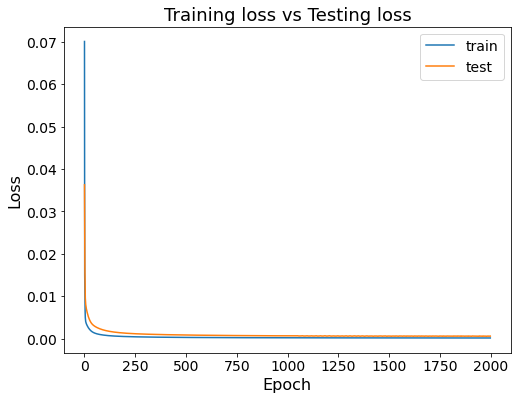

In [35]:
lr = 0.00001
EPOCHS = 2000
model_crnn_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

history = model_crnn_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [50]:
model_crnn_60.save('saved_model/rnn_conv')

INFO:tensorflow:Assets written to: saved_model/rnn_conv/assets


INFO:tensorflow:Assets written to: saved_model/rnn_conv/assets


In [36]:
# from keras.models import load_model

# model_load = load_model('saved_model/model_rnn_60')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


### Performance

In [37]:
yhat = model_crnn_60.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

602/602 [==============================] - 5s 7ms/step
inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [38]:
# inv_y

In [39]:
# inv_yhat

In [40]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [41]:
error = inv_yhat - inv_y
error

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.044693,0.074052,0.037464,0.074497,-0.049939,-0.003192,-0.003601,0.108440,-0.022683,-0.086483,...,-0.046627,0.249340,0.042779,0.152769,-0.000134,0.262663,-0.030223,0.067095,-0.041831,0.208310
1,-0.082607,0.021441,0.039966,0.083583,-0.031812,-0.139176,-0.023425,0.120730,-0.052365,-0.046240,...,-0.005278,0.230219,0.003721,0.128013,-0.018952,0.182862,0.034296,0.122373,0.011166,0.160247
2,-0.047453,-0.064989,0.031964,0.088578,-0.006927,-0.062078,0.041967,0.146356,0.021123,-0.005862,...,-0.060231,0.235330,0.021471,0.250692,0.070142,0.225493,-0.047878,0.014956,-0.006062,0.146580
3,-0.043864,-0.076791,0.015631,0.142113,0.003426,-0.017360,-0.004130,0.109155,-0.089589,-0.090241,...,0.037635,0.202661,-0.024601,0.045793,0.072432,0.180018,-0.116659,-0.073572,-0.094152,0.048525
4,0.014823,-0.008718,-0.001960,0.189441,-0.034097,-0.059579,-0.063404,0.136314,-0.005269,0.090639,...,0.050378,0.164759,-0.100206,-0.043741,-0.008163,0.040735,-0.117464,-0.104456,-0.081019,0.077799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,0.041639,0.005029,-0.032366,0.214282,-0.048794,-0.032661,-0.092249,0.085409,-0.038889,0.022936,...,0.030301,0.080771,-0.125619,-0.140675,-0.004313,0.121022,-0.072213,-0.076849,-0.064009,0.120501
19245,-0.008630,-0.001585,-0.034752,0.203836,-0.010782,0.016239,-0.109675,0.144020,0.050233,0.041815,...,-0.018718,0.141204,-0.050785,-0.098509,-0.049177,0.167394,0.042184,0.007490,-0.020326,0.257081
19246,-0.058511,0.019859,-0.098567,0.208412,0.046209,0.035410,-0.011906,0.228974,-0.087533,-0.012052,...,-0.055123,0.113771,-0.007807,-0.013746,-0.022336,0.194335,0.009107,-0.009335,-0.067038,0.137402
19247,0.021484,0.080047,-0.003184,0.262807,-0.102105,0.016557,-0.103867,0.040132,-0.126804,0.051979,...,0.001649,0.198128,0.024178,-0.016857,-0.041920,0.153713,-0.002236,0.046407,-0.113865,0.178468


In [42]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [43]:
len(error_19_20)

17544

In [49]:
inv_y.to_csv('./output/inv_y_rnn_cnn.csv')
inv_yhat.to_csv('./output/inv_yhat_rnn_cnn.csv')
error.to_csv('output/error_rnn_cnn.csv')

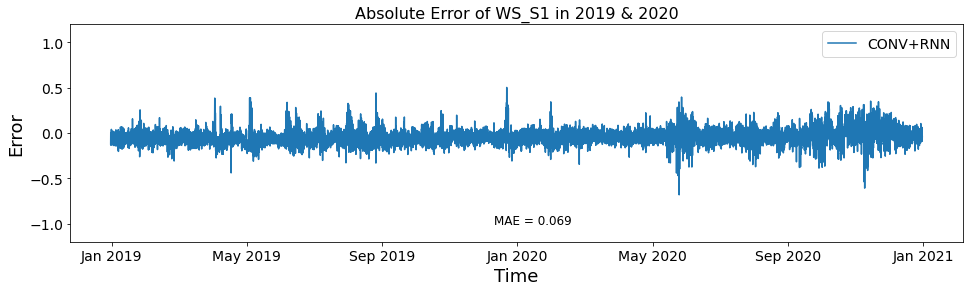

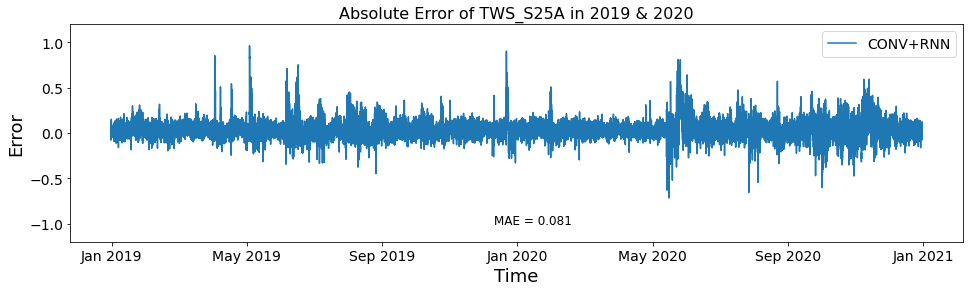

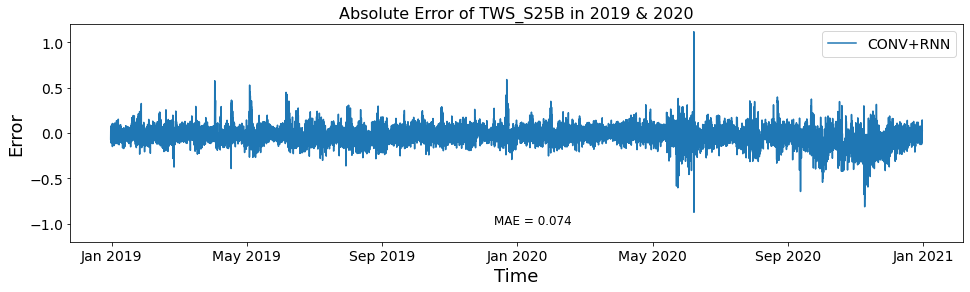

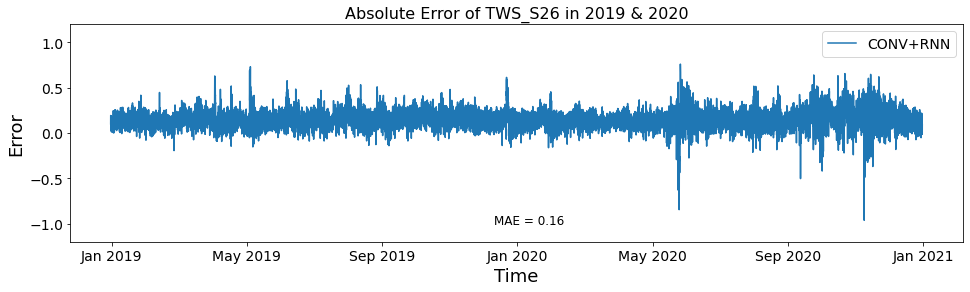

In [45]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
# locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26', 'STORAGE', 'HWS_S25A', 'HWS_S25B']
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([68, 69, 70, 71]):
    plt.plot(error.iloc[-17544:, col], label='CONV+RNN')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.2, 1.2)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -1, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()